In [1]:
import numpy as np
import pandas as pd
from scipy import stats

In [86]:
# method
alphas = np.linspace(.025,.95,30)
filesScore = ["Pij_2017.csv","Pij_2018.csv"]

filesPercs = ["2017_win_perc.csv","2018_win_perc.csv"]
namesCols = ["win_perc_2017","win_perc_2018"]

In [87]:
def alpha_optimize_pc(method,alphas,filesScore,filesPercs,namesCols,nSims = 10000,weighted = True):
    # intializing two vectors to store results
    score_perc_total = np.zeros(len(alphas))
    wins_perc_total = np.zeros(len(alphas))
    score_perc_S2 = np.zeros(len(alphas))
    indexer = 0
    
    # iterating over all alphas
    for alpha_try in alphas:
        
        if(alpha_try >= .8):
            nSims_use = nSims
        else:
            nSims_use = 5000
        
        # initializing the two correlations
        mc_perc_score = 0
        mc_perc_wins = 0
        
        # intializing a vector to get each percentage (for getting a standard deviation)
        sd_vect = np.zeros(len(filesScore) - 1)
        
        # iterating over all years (we lose a year since we don't have anything 
        # to regress the 2019 data on)
        for year_of_data in np.arange(len(filesScore) - 1):
            
            # reading in the data
            data = pd.read_csv(filesScore[year_of_data],index_col=0)
            stats1 = pd.read_csv(filesPercs[year_of_data],index_col=0)
            stats2 = pd.read_csv(filesPercs[year_of_data + 1],index_col=0)
            # converting to a numpy array
            data2 = np.array(data)
            
            if(weighted == False):
                data2[data2!=0] = 1
            
            # making the Pij matrix
            Pij = data2/data2.sum(axis=0)
            
            # If we want the teleportation probabilties unifrom,
            # or based on team winning perc
            if method == 0:
                # making the teleporting probabilities uniform
                v = np.ones(32)/32
                v = v[np.newaxis]
                v = v.T
                # Setting alpha
                alpha = alpha_try
                # Setting eT
                eT = np.ones(32)[np.newaxis]   
            else:
                # making the teleporting probabilities proportional to
                # the teams winning percentages
                v = np.array(stats1[namesCols[year_of_data]])
                v = v[np.newaxis]
                v = v.T
                v = v/np.sum(v)
                # Setting alpha
                alpha = alpha_try
                # Setting eT
                eT = np.ones(32)[np.newaxis]
                
            # initializing our first guess
            x0 = np.ones(32)/32
            x0 = x0[np.newaxis]
            x0 = x0.T
            
            # performing the simulation
            for i in range(nSims_use):
                x0 = alpha*np.dot(Pij,x0) + (1-alpha)*v

            # defining the team names
            team_names = np.array(data.columns.get_values())
            
            # ordering the team's by their score
            mask = np.argsort(np.squeeze(x0))[::-1]
            x0_df = np.squeeze(x0[mask])
            team_names_df = team_names[mask]
            
            # forming a data frame
            teamrank = {'Team': team_names_df, 'score': x0_df, 'wins': 32*16/2*x0_df}
            teamrank_df = pd.DataFrame(data=teamrank)
            
            output = pd.merge(teamrank_df,
                  stats1,
                  left_on = "Team",
                  right_on = "team",
                  how = "inner")

            output = pd.merge(output,
                  stats2,
                  left_on = "Team",
                  right_on = "team",
                  how = "inner")
            
            # Figuring out ranks
            output['rank1'] = output[namesCols[year_of_data]].rank(ascending = False)
            output['rank2'] = output[namesCols[year_of_data + 1]].rank(ascending = False)
            
            # Computing the percent change correct
            score_rank = np.arange(32) + 1
            rank1 = np.array(output["rank1"])
            rank2 = np.array(output["rank2"])
            
            tau_score,p_value = stats.kendalltau(score_rank, rank2)
            tau_wins,p_value = stats.kendalltau(rank1, rank2)
            
            # Storing the results
            mc_perc_wins += tau_wins
            mc_perc_score += tau_score
            sd_vect[year_of_data] = tau_score
            
        # Updating the percentages
        wins_perc_total[indexer] = mc_perc_wins/(len(filesScore) - 1)
        score_perc_total[indexer] = mc_perc_score/(len(filesScore) - 1)
        score_perc_S2[indexer] = np.std(sd_vect)/np.sqrt(len(filesScore) - 1)
        indexer += 1
        
    return score_perc_total,score_perc_S2,wins_perc_total

In [88]:
score_corr0,score_perc_S20,wins0 = alpha_optimize_pc(0,alphas,filesScore,filesPercs,namesCols)

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline

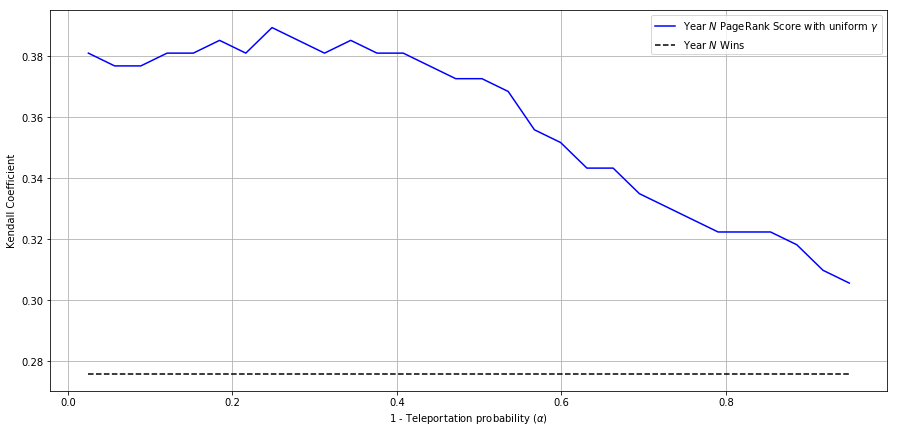

In [92]:
plt.figure(figsize=(15,7))

plt.plot(alphas,score_corr0,'b-',label = r'Year $N$ PageRank Score with uniform $\gamma$')
plt.plot(alphas,wins0,'k--',label = r'Year $N$ Wins')
plt.xlabel(r'1 - Teleportation probability ($\alpha$)')
plt.ylabel("Kendall Coefficient")
plt.legend()
plt.grid()
plt.show()